In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from concurrent.futures import ThreadPoolExecutor
from pyvis.network import Network

In [ ]:
country_net = nx.read_graphml("../networks/graphml/countrys_network.graphml")
city_net = nx.read_graphml("../networks/graphml/cities_network.graphml")
combined_net = nx.read_graphml("../networks/graphml/combined_network.graphml")

In [ ]:
def get_jaccard_weight(G, u, v):
    # Get neighbors regardless of direction
    set_u = set(nx.all_neighbors(G, u))
    set_v = set(nx.all_neighbors(G, v))
    union_len = len(set_u.union(set_v))
    if union_len == 0: return -1
    return -(len(set_u.intersection(set_v)) / union_len) - 1

def plot_network(G, title):

    # # For every edge (u, v), set weight based on shared neighbors
    jacquard_weights = []
    with ThreadPoolExecutor() as executor:
        futures = []
        for u, v in G.edges():
            futures.append(executor.submit(get_jaccard_weight, G, u, v))
        for future in futures:
            jacquard_weights.append(future.result())

    min_jaccard = min(jacquard_weights)
    max_jaccard = max(jacquard_weights)
    for (u, v), weight in zip(G.edges(), jacquard_weights):
        normalized_weight = 0.5 * ((weight - min_jaccard) / (max_jaccard - min_jaccard)) if max_jaccard != min_jaccard else 0
        weight = -normalized_weight**2 + normalized_weight
        G[u][v]['weight'] = weight

    fig, ax = plt.subplots(figsize=(16, 10))

    pos = nx.spring_layout(G, method='energy', weight='weight', k=10, iterations=500)

    degrees = np.array([G.degree(n) for n in G.nodes()])
    norm = Normalize(degrees.min(), degrees.max())
    normed_degrees = norm(degrees)

    cmap = plt.get_cmap('coolwarm')  # blue to red
    node_colors = cmap(-normed_degrees**2 + 2*normed_degrees)
    node_map = dict(zip(G.nodes(), node_colors))

    node_size=(-normed_degrees**2 + 2*normed_degrees)*300 + 50

    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_colors, edgecolors=node_colors, alpha=0.5, ax=ax)
    nx.draw_networkx_edges(G, pos, edge_color=[node_map[v] for u, v in G.edges()], alpha=0.3, ax=ax)

    # Keep the lower 50% of labels by degree and the top 10% of labels by degree
    degrees_sorted = sorted(degrees)
    degree_threshold_low = degrees_sorted[int(0.5 * len(degrees_sorted))]
    degree_threshold_high = degrees_sorted[int(0.9 * len(degrees_sorted))]
    labels = {n: n for n in G.nodes() if G.degree(n) >= degree_threshold_high or G.degree(n) <= degree_threshold_low}

    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, alpha=0.7, ax=ax)

    ax.set_title(title, fontsize=18, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()

    return fig, ax

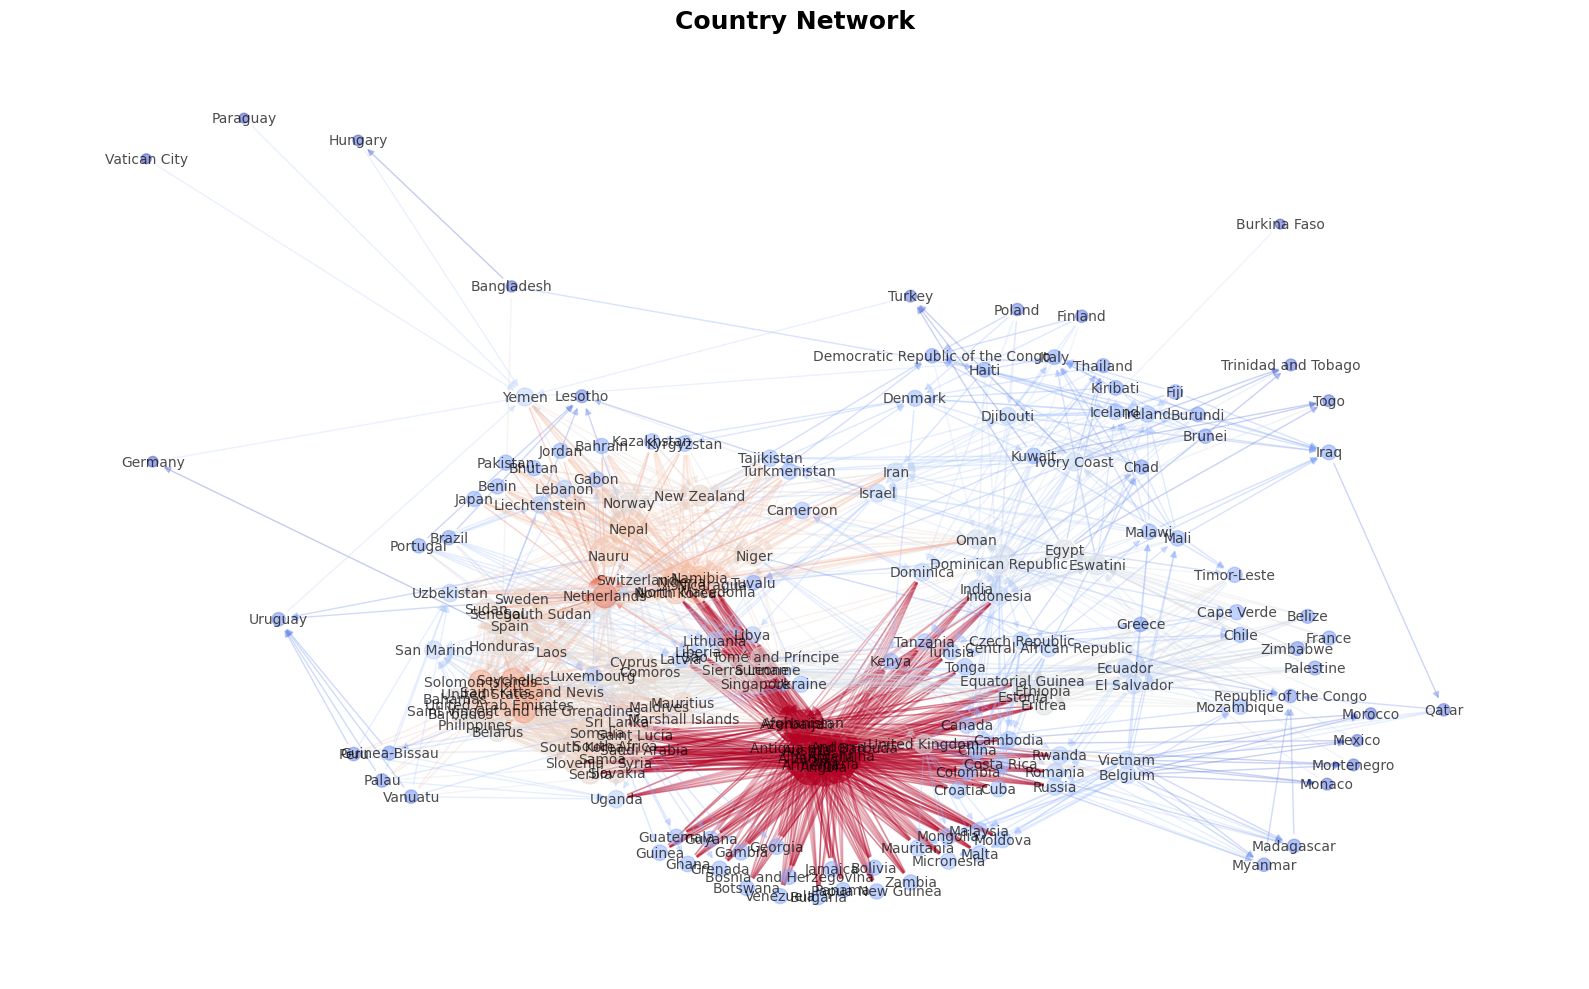

In [ ]:
fig, ax = plot_network(country_net, "Country Network")
plt.show(fig)
fig.savefig("country_net.png", dpi=1000)

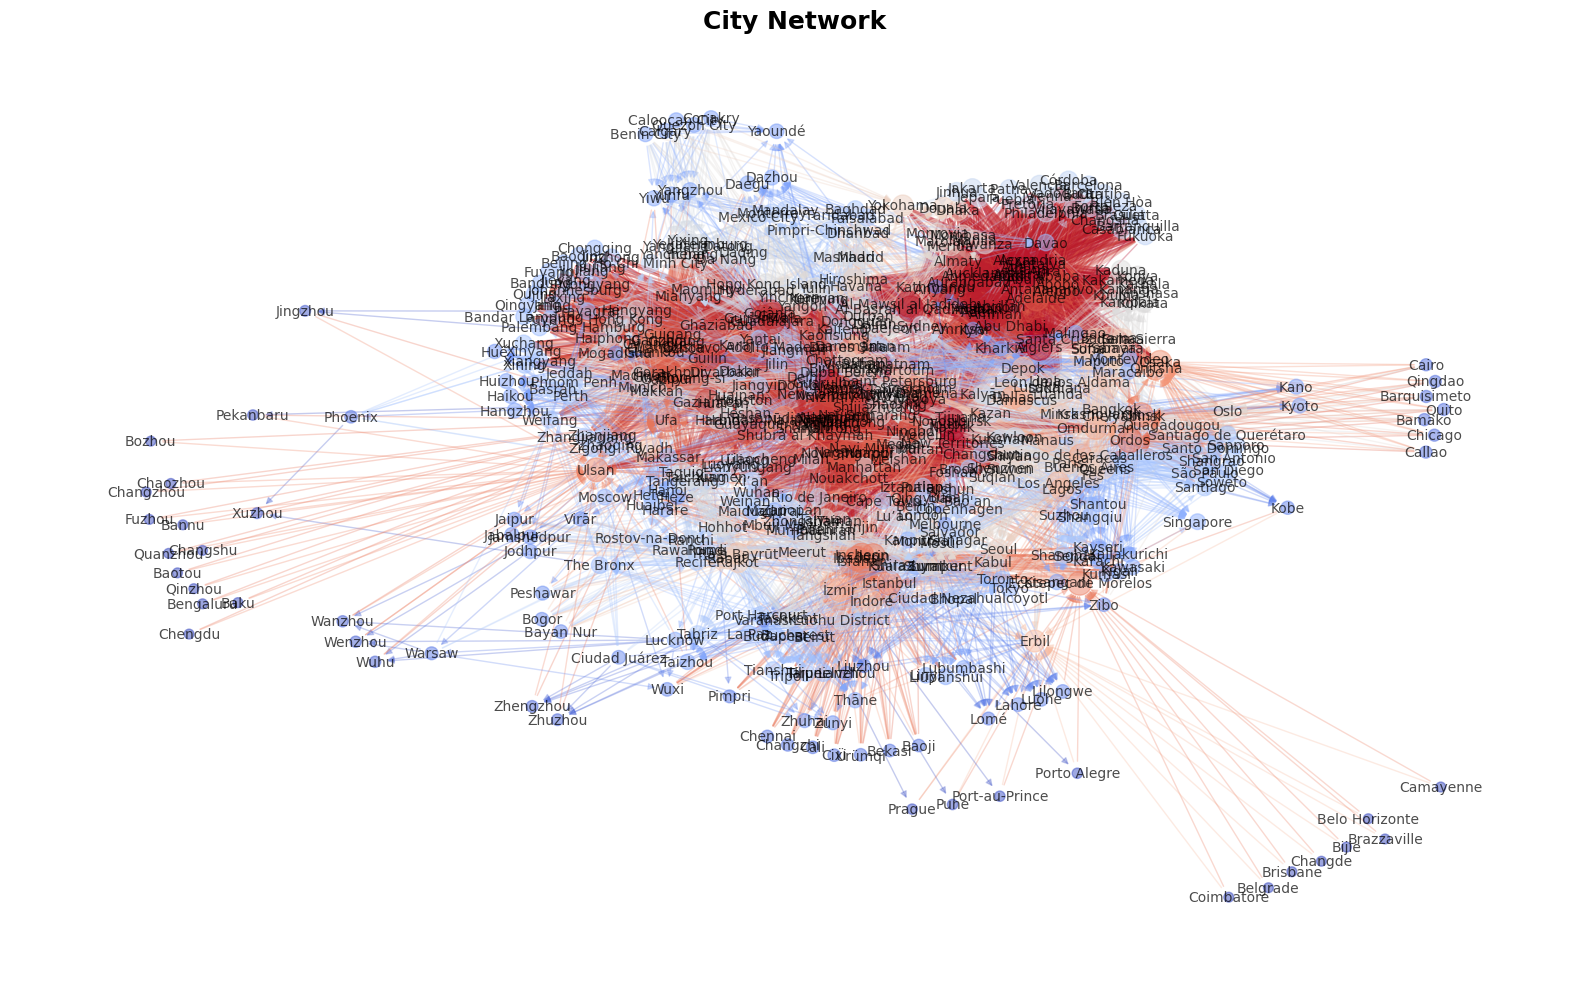

In [ ]:
fig, ax = plot_network(city_net, "City Network")
plt.show(fig)
fig.savefig("city_net.png", dpi=1000)

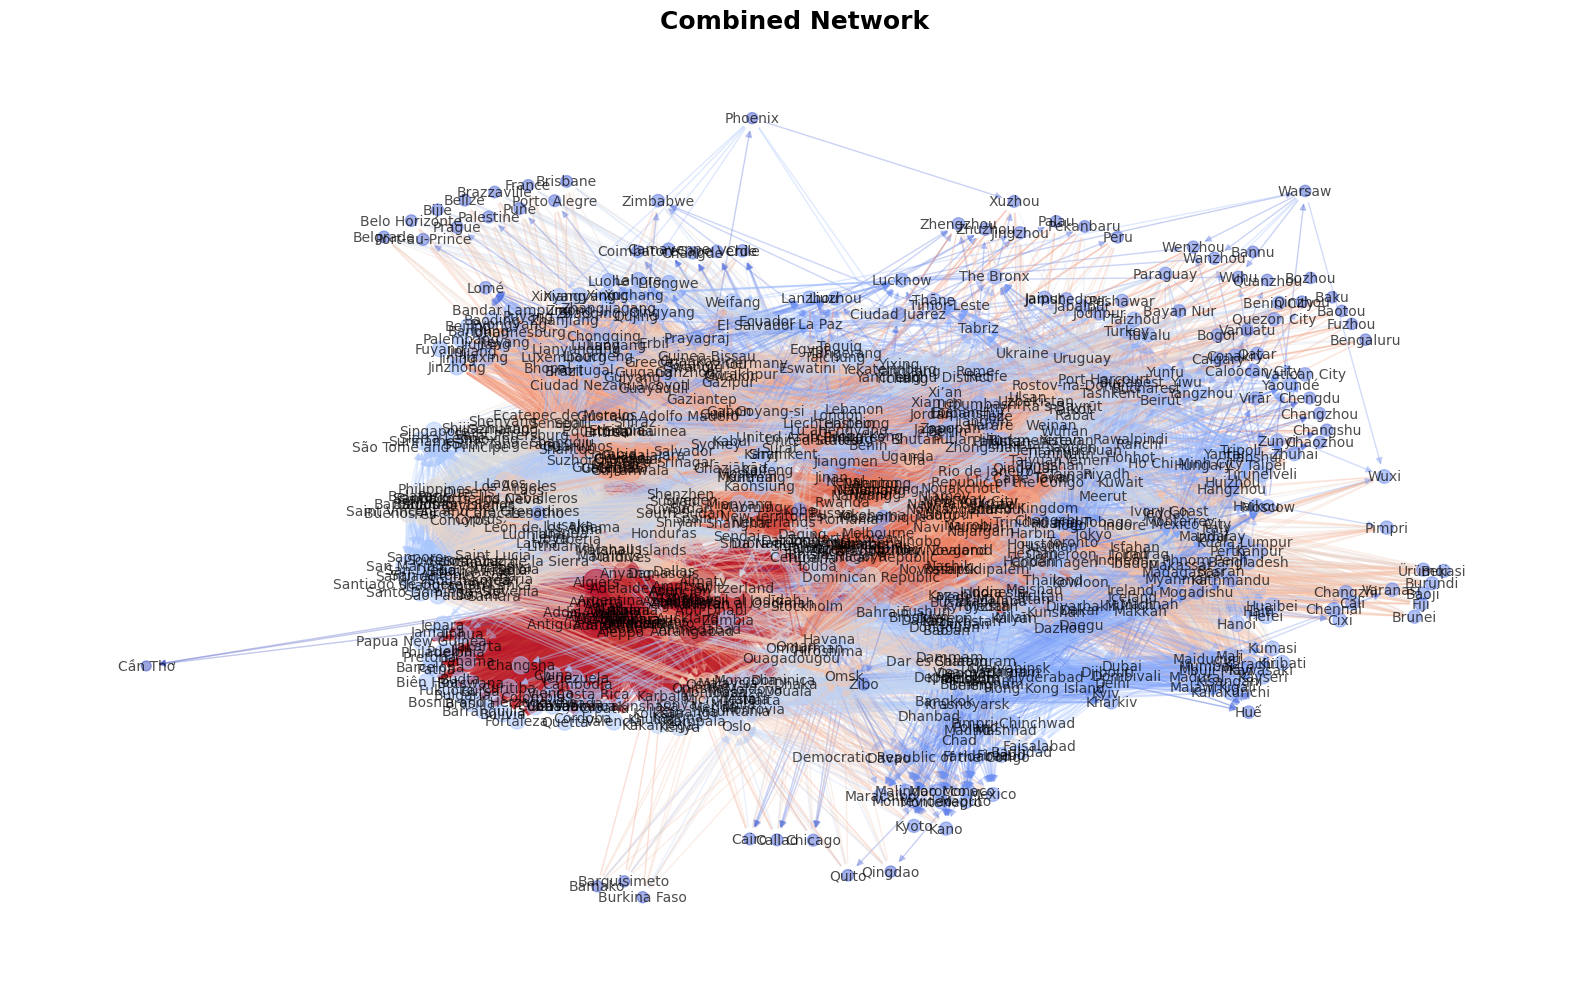

In [ ]:
fig, ax = plot_network(combined_net, "Combined Network")
plt.show(fig)
fig.savefig("combined_net.png", dpi=1000)

In [ ]:
# set cdn_resources to "in_line" to save all files in one html
g = Network(notebook=True, cdn_resources="in_line")
g.from_nx(combined_net)
# g.show_buttons(filter_=['physics'])
g.show("combined_net.html")

---